### CNN Visualization

In [0]:
from __future__ import print_function
import pandas as pd
import numpy as np
import time
from keras.preprocessing.image import save_img
from keras.applications import vgg16
from keras import backend as K
import ast
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML, Image
import cv2
rc('animation', writer='imagemagick')

In [0]:
CATEGORY = 'cat'
name = CATEGORY + '.csv'
df = pd.read_csv(name, nrows=2000)# read 2000 rows of data within category "cat".
df['drawing'] = df['drawing'].apply(ast.literal_eval)
original_shape = (256,256)
BASE_SIZE = 256

In [0]:
def draw(raw_strokes, size=256, lw=3):# function to return a image matrix
    
    step = len(raw_strokes)
    max_x = max( [max(x)  for x, y in raw_strokes ] )
    max_y = max( [max(y)  for x, y in raw_strokes ] )
   
    max_x, max_y =  max_x + 1, max_y + 1
    img = np.zeros((max_y, max_x), np.uint8)

   
    for i in range(step):
        stroke = raw_strokes[i]
        
        x,y=stroke[0], stroke[1]
        for i in range(len(x) - 1):
            _ = cv2.line(img, (x[i], y[i]),
                         (x[i + 1], y[i + 1]), 255, lw)
   
   
    top = max ( (BASE_SIZE - max_y) // 2 , 0 )
    bottom = max ( BASE_SIZE - top - max_y , 0)
   
    left = max (  (BASE_SIZE - max_x) // 2, 0 )
    right = max ( BASE_SIZE - max_x - left, 0 )

    img =  cv2.copyMakeBorder(img,top,bottom,left,right,cv2.BORDER_CONSTANT)
    return img

def merge_pics(df, num_pictures): #function to overlay different pics and return a list of all image matrix  and a overlaid image matrix

  combination = np.zeros((256,256))
  for k in range(num_pictures):
    img = draw(df.loc[k,'drawing'], size=256, lw=1)
    
    flat = img.ravel()
    imgvector = np.matrix(flat)
    if k == 0:
          imgmatrix = imgvector
    else:
          imgmatrix = np.r_[imgmatrix,imgvector]
    
    for i in range(len(img)):
      for j in range(len(img[i])):
        if img[i][j] > 0 and combination[i][j] < 255:
          combination[i][j] += 1
  return combination, imgmatrix

### Draw the overlaid picture

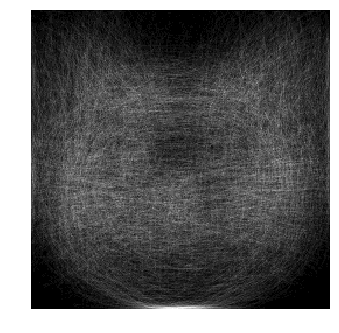

In [29]:
comb, imgmatrix = merge_pics(df, 1000)
imgmatrix_t = np.transpose(imgmatrix)
mean_img = np.int16(imgmatrix_t.mean(axis = 1))
mean_img_arrary = np.asarray(mean_img.reshape((256,256)))
plt.figure()
plt.imshow(mean_img_arrary, cmap = plt.get_cmap("gray"))
plt.axis("off")
plt.show()

In [0]:
np.savetxt("mean_img.csv", mean_img_arrary, delimiter=",")

In [0]:
input_img_data = pd.read_csv("mean_img.csv", header = None)
input_img_data = input_img_data.values

(256, 256)

### Preparation of the CNN's data

In [0]:
input_img_data = input_img_data.reshape(1, 256, 256,1)
input_img_data= np.reshape(input_img_data, (len(input_img_data), 256*256))
input_img_data = np.dstack([input_img_data] * 3)
input_img_data = input_img_data.reshape(-1, 256,256,3)

### Build a VGG Model

In [0]:
# dimensions of the generated pictures for each filter.
img_width = 256
img_height = 256

# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
layer_names = ['block1_conv1',  "block2_conv1", "block3_conv1", 
               "block4_conv1", "block5_conv1"]
nums_filters = [16, 32, 128, 200, 200]


# util function to convert a tensor into a valid image


def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #if K.image_data_format() == 'channels_first':
        #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


# build the VGG16 network with ImageNet weights
model = vgg16.VGG16(weights='imagenet', include_top=False)
print('Model loaded.')

model.summary()

# this is the placeholder for the input images
input_img = model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


kept_filters = []

Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0      

In [0]:
for i in range(len(layer_names)):
  layer_name = layer_names[i]
  num_filters = nums_filters[i]
  for filter_index in range(16):
      # we only scan through the first 200 filters,
      # but there are actually 512 of them
      print('Processing filter %d' % filter_index)
      start_time = time.time()

      # we build a loss function that maximizes the activation
      # of the nth filter of the layer considered
      layer_output = layer_dict[layer_name].output
      loss = K.mean(layer_output[:, :, :, filter_index])

      # we compute the gradient of the input picture wrt this loss
      grads = K.gradients(loss, input_img)[0]

      # normalization trick: we normalize the gradient
      grads = normalize(grads)

      # this function returns the loss and grads given the input picture
      iterate = K.function([input_img], [loss, grads])

      # step size for gradient ascent
      step = 1.

      # we run gradient ascent for 20 steps
      for i in range(10):
          loss_value, grads_value = iterate([input_img_data])
          input_img_data += grads_value * step

          print('Current loss value:', loss_value)
          if loss_value <= 0.:
              # some filters get stuck to 0, we can skip them
              break

      # decode the resulting input image
      if loss_value > 0:
          img = deprocess_image(input_img_data[0])
          kept_filters.append((img, loss_value))
      end_time = time.time()
      print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

  # we will stich the best 64 filters on a 8 x 8 grid.
  n = 4

  # the filters that have the highest loss are assumed to be better-looking.
  # we will only keep the top 64 filters.
  kept_filters.sort(key=lambda x: x[1], reverse=True)
  kept_filters = kept_filters[:n * n]

  # build a black picture with enough space for
  # our 8 x 8 filters of size 128 x 128, with a 5px margin in between
  margin = 5
  width = n * img_width + (n - 1) * margin
  height = n * img_height + (n - 1) * margin
  stitched_filters = np.zeros((width, height, 3))

  # fill the picture with our saved filters
  for i in range(n):
      for j in range(n):
          img, loss = kept_filters[i * n + j]
          width_margin = (img_width + margin) * i
          height_margin = (img_height + margin) * j
          stitched_filters[
              width_margin: width_margin + img_width,
              height_margin: height_margin + img_height, :] = img

  # save the result to disk
  save_img('stitched_filters_%s_%dx%d.png' % (layer_name, n, n), stitched_filters)

Processing filter 0
Current loss value: 0.75149816
Current loss value: 1.1117134
Current loss value: 1.5056549
Current loss value: 1.8995739
Current loss value: 2.2938251
Current loss value: 2.6875312
Current loss value: 3.0817332
Current loss value: 3.4760342
Current loss value: 3.87035
Current loss value: 4.2643576
Filter 0 processed in 1s
Processing filter 1
Current loss value: 0.18214443
Current loss value: 3.758356
Current loss value: 7.334199
Current loss value: 10.909689
Current loss value: 14.486883
Current loss value: 18.061638
Current loss value: 21.63662
Current loss value: 25.211733
Current loss value: 28.790295
Current loss value: 32.36664
Filter 1 processed in 1s
Processing filter 2
Current loss value: 0.31582445
Current loss value: 1.0944912
Current loss value: 1.87311
Current loss value: 2.652113
Current loss value: 3.430447
Current loss value: 4.209345
Current loss value: 4.987952
Current loss value: 5.766344
Current loss value: 6.545842
Current loss value: 7.3238544
F